In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import AdamW,Adam
import matplotlib.pyplot as plt
from google.colab import files


In [ ]:
files.upload()

In [ ]:
#definition of fourier convolution

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)

        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 100)
        self.output_layer = nn.Linear(100, 1)

        self.activation = torch.nn.GELU()

    def get_grid(self,x):
        res=x.shape[1]
        grid=torch.linspace(0,1,res)
        temporary_tensor=torch.zeros(x.shape[0], x.shape[1], 2)
        temporary_tensor[:,:,0]=x.squeeze()
        for i in range(x.shape[0]):
          temporary_tensor[i,:,1]=grid
        return temporary_tensor

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        x = self.get_grid(x)
        x = self.linear_p(x)

        x = x.permute(0, 2, 1)

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)

        x = self.output_layer(x)
        return x


Data preproccessing:

In [ ]:
n=64  #selecting the train and test trajectories
x_data=torch.from_numpy(np.load('train_sol.npy')).type(torch.float32)[:,0,:] #trajectories at time t=0 (128x64)
y_data=torch.from_numpy(np.load('train_sol.npy')).type(torch.float32)[:,4,:] #trajectories at time t=1 (128x64)


input_train=x_data[:n,:] #first 64 as training at time t=0 -> initial conditions 64x64x2(traj,res,function and grid)
output_train=y_data[:n,:] #sol at time t=1 -> final conditions
input_test=x_data[n:,:]  #last 64 as validation
output_test=y_data[n:,:]

batch_size=16

training_set=DataLoader(TensorDataset(input_train,output_train),batch_size=batch_size,shuffle=True)
testing_set=DataLoader(TensorDataset(input_test,output_test),batch_size=batch_size,shuffle=True)

In [ ]:
learning_rate = 0.001
epochs= 500
step_size = 50
gamma = 0.50

In [ ]:
modes = 16
width = 64
fno = FNO1d(modes, width) # model

In [ ]:
def l2loss(output_pred,real_output):
  return (torch.mean((output_pred - real_output) ** 2) / torch.mean(real_output ** 2)) ** 0.5 * 100

In [ ]:
optimizer = AdamW(fno.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


#l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l2loss(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)



######### Epoch: 0  ######### Train Loss: 98.76697540283203  ######### Relative L2 Test Norm: 96.20621681213379
######### Epoch: 1  ######### Train Loss: 93.72891426086426  ######### Relative L2 Test Norm: 85.87048530578613
######### Epoch: 2  ######### Train Loss: 82.99407768249512  ######### Relative L2 Test Norm: 77.85026741027832
######### Epoch: 3  ######### Train Loss: 80.04380226135254  ######### Relative L2 Test Norm: 75.16288757324219
######### Epoch: 4  ######### Train Loss: 74.71646881103516  ######### Relative L2 Test Norm: 75.23087310791016
######### Epoch: 5  ######### Train Loss: 75.28898429870605  ######### Relative L2 Test Norm: 72.4518051147461
######### Epoch: 6  ######### Train Loss: 70.11868476867676  ######### Relative L2 Test Norm: 67.64945983886719
######### Epoch: 7  ######### Train Loss: 65.94647121429443  ######### Relative L2 Test Norm: 63.44387912750244
######### Epoch: 8  ######### Train Loss: 57.879767417907715  ######### Relative L2 Test Norm: 55.2631969

Relative L2 error:  3.056262969970703


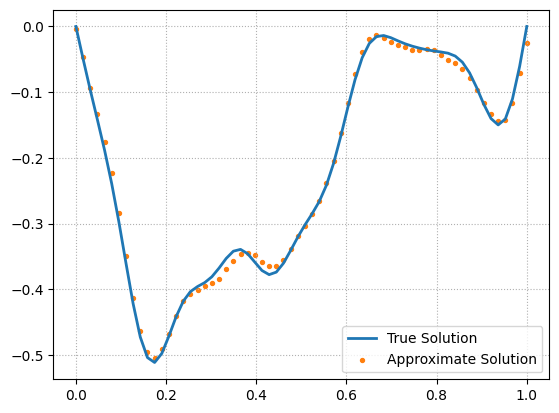

In [ ]:
idx_data = 34
input_function_test_n = input_test[idx_data, :].unsqueeze(0)
output_function_test_n = output_test[idx_data, :].unsqueeze(0)

output_function_test_pred_n = fno(input_function_test_n)

plt.figure()
plt.grid(True, which="both", ls=":")
plt.plot(torch.linspace(0,1,64), output_function_test_n[0].detach(), label="True Solution", c="C0", lw=2)
plt.scatter(torch.linspace(0,1,64), output_function_test_pred_n[0].detach(), label="Approximate Solution", s=8, c="C1")
p = 2
err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()

Testing on the sol dataset:

In [ ]:
x_sol=torch.from_numpy(np.load('test_sol.npy')).type(torch.float32)[:,0,:]
y_sol=torch.from_numpy(np.load('test_sol.npy')).type(torch.float32)[:,4,:]

testing_dataset=DataLoader(TensorDataset(x_sol,y_sol),batch_size=len(x_sol))

with torch.no_grad():
    fno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch) in enumerate(testing_dataset):
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_dataset)
    print("Relative L2 Test Norm:", test_relative_l2)
    l_test=test_relative_l2

Relative L2 Test Norm: 4.187814712524414


Resolution 32:

In [ ]:
x_32=torch.from_numpy(np.load('test_sol_res_32.npy')).type(torch.float32)[:,0,:]
y_32=torch.from_numpy(np.load('test_sol_res_32.npy')).type(torch.float32)[:,1,:]

testing_32=DataLoader(TensorDataset(x_32,y_32),batch_size=len(x_32))

with torch.no_grad():
    fno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch) in enumerate(testing_32):
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_32)
    print("Relative L2 Test Norm:", test_relative_l2)
    l_32=test_relative_l2

Relative L2 Test Norm: 8.392383575439453


Resolution 64:

In [ ]:
x_64=torch.from_numpy(np.load('test_sol_res_64.npy')).type(torch.float32)[:,0,:]
y_64=torch.from_numpy(np.load('test_sol_res_64.npy')).type(torch.float32)[:,1,:]
testing_64=DataLoader(TensorDataset(x_64,y_64),batch_size=len(x_64))

with torch.no_grad():
    fno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch) in enumerate(testing_64):
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_64)
    print("Relative L2 Test Norm:", test_relative_l2)
    l_64=test_relative_l2

Relative L2 Test Norm: 4.418882369995117


Resolution 96:

In [ ]:
x_96=torch.from_numpy(np.load('test_sol_res_96.npy')).type(torch.float32)[:,0,:]
y_96=torch.from_numpy(np.load('test_sol_res_96.npy')).type(torch.float32)[:,1,:]
testing_96=DataLoader(TensorDataset(x_96,y_96),batch_size=len(x_96))

with torch.no_grad():
    fno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch) in enumerate(testing_96):
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_96)
    print("Relative L2 Test Norm:", test_relative_l2)
    l_96=test_relative_l2


Relative L2 Test Norm: 4.769369125366211


Resolution 128:

In [ ]:
x_128=torch.from_numpy(np.load('test_sol_res_128.npy')).type(torch.float32)[:,0,:]
y_128=torch.from_numpy(np.load('test_sol_res_128.npy')).type(torch.float32)[:,1,:]
testing_128=DataLoader(TensorDataset(x_128,y_128),batch_size=len(x_128))

with torch.no_grad():
    fno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch) in enumerate(testing_128):
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_128)
    print("Relative L2 Test Norm:", test_relative_l2)
    l_128=test_relative_l2



Relative L2 Test Norm: 5.300142288208008


Overall the average L2 error seems to be coeherent around the trained resolution, at 64 and 96. However the error notably increases at 128, and at 32 it peaks at around 8/9%. Therefore the error is not mesh-independent.

Out-of-distribution testing:

In [ ]:
x_ood=torch.from_numpy(np.load('test_sol_OOD.npy')).type(torch.float32)[:,0,:]
y_ood=torch.from_numpy(np.load('test_sol_OOD.npy')).type(torch.float32)[:,1,:]
testing_ood=DataLoader(TensorDataset(x_ood,y_ood),batch_size=len(x_ood))

with torch.no_grad():
    fno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch) in enumerate(testing_ood):
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_ood)
    print("Relative L2 Test Norm:", test_relative_l2)
    l_ood=test_relative_l2


Relative L2 Test Norm: 8.577457427978516


The out-of-distribution error is 3/4% higher than the validation error of task1

Building the all2all dataset

In [ ]:
#---------------------
# Time-conditional BN:
#---------------------

class FILM(torch.nn.Module):
    def __init__(self,
                channels,
                use_bn = True):
        super(FILM, self).__init__()
        self.channels = channels
        self.inp2scale = nn.Linear(in_features=1, out_features=channels, bias=True)
        self.inp2bias = nn.Linear(in_features=1, out_features=channels, bias=True)

        if use_bn:
            self.norm = nn.BatchNorm1d(channels)
        else:
            self.norm = nn.Identity()

    def forward(self, x, time):

        x = self.norm(x)
        time = time.reshape(-1,1).type_as(x)
        scale     = self.inp2scale(time)
        bias      = self.inp2bias(time)
        scale = scale.unsqueeze(2).expand_as(x)
        bias  = bias.unsqueeze(2).expand_as(x)

        return x * scale + bias

In [ ]:
class FNO1d_2(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d_2, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.norm0=FILM(self.width)
        self.norm2=FILM(self.width)
        self.norm4=FILM(self.width)
        self.norm6=FILM(self.width)
        self.norm8=FILM(self.width)
        self.norm10=FILM(self.width)

        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect4 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect6 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect8 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect10 = SpectralConv1d(self.width, self.width, self.modes1)

        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)
        self.lin4 = nn.Conv1d(self.width, self.width, 1)
        self.lin6 = nn.Conv1d(self.width, self.width, 1)
        self.lin8 = nn.Conv1d(self.width, self.width, 1)
        self.lin10 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.GELU()

    def get_grid(self,x):
        res=x.shape[1]
        grid=torch.linspace(0,1,res)
        temporary_tensor=torch.zeros(x.shape[0], res, 2)
        temporary_tensor[:,:,0]=x.squeeze()
        for i in range(x.shape[0]):
            temporary_tensor[i,:,1]=grid
        return temporary_tensor

    def fourier_layer(self, x, spectral_layer1, conv_layer1,time,bn1):
        out=spectral_layer1(x)+conv_layer1(x) #global and local convolution
        out=bn1(out,time) #normalize with time
        out=self.activation(out)
        return out

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x, time):
        x = self.get_grid(x)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)

        x = F.pad(x, [0, self.padding])
        x = self.fourier_layer(x, self.spect0, self.lin0, time, self.norm0)
        x = self.fourier_layer(x, self.spect2, self.lin2, time, self.norm2)
        x = self.fourier_layer(x, self.spect4, self.lin4, time, self.norm4)
        x = self.fourier_layer(x, self.spect6, self.lin6, time, self.norm6)
        x = self.fourier_layer(x, self.spect10, self.lin10, time, self.norm10)
        x = x[..., :-self.padding]
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


In [ ]:
n=64
all_snap_train=torch.from_numpy(np.load('train_sol.npy')).type(torch.float32)[:n,:,:] #training with all time snapshots 64x5x64
time_indexes=torch.tensor([(i, j) for i in range(5) for j in range(i+1,5) if i<4]) #all valid indexes pairs
all2all_input_train=torch.zeros(len(time_indexes)*n,64)
all2all_output_train=torch.zeros(len(time_indexes)*n,64)
time_step_train=torch.zeros(len(time_indexes)*64)
q=0
for k in range(n):
    for i,j in time_indexes:
        all2all_input_train[q,:]=all_snap_train[k,i,:] #input at time i
        all2all_output_train[q,:]=all_snap_train[k,j,:] #output at time j
        time_step_train[q]=(j-i)/4   #delta t
        q+=1

batch_s=32
all2all_train_dat=DataLoader(TensorDataset(all2all_input_train,all2all_output_train,time_step_train),batch_size=batch_s,shuffle=True)

In [ ]:
all_snap_test=torch.from_numpy(np.load('train_sol.npy')).type(torch.float32)[n:,:,:]  #validation 64x5x64
all2all_input_test=torch.zeros(64,64)
all2all_output_test=torch.zeros(64,64)
time_step_test=torch.zeros(64)
q=0
for k in range(n):
    all2all_input_test[q,:]=all_snap_test[k,0,:]
    all2all_output_test[q,:]=all_snap_test[k,4,:] #only prediction at t=1
    time_step_test[q]=1
    q+=1

all2all_test_dat=DataLoader(TensorDataset(all2all_input_test, all2all_output_test, time_step_test),batch_size=batch_s,shuffle=True)

In [ ]:
learning_rate = 0.001
epochs= 100
step_size = 50
gamma = 0.50
allfno=FNO1d_2(16,64)

In [ ]:
optimizer = AdamW(allfno.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch, time_batch) in enumerate(all2all_train_dat):
        optimizer.zero_grad()
        output_pred_batch = allfno(input_batch,time_batch).squeeze(2)
        loss_f = l2loss(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(all2all_train_dat)

    scheduler.step()

    with torch.no_grad():
        allfno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output, time_batch) in enumerate(all2all_test_dat):
            output_pred_batch = allfno(input_batch,time_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output) ** 2) / torch.mean(output ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(all2all_test_dat)

        if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)



######### Epoch: 0  ######### Train Loss: 59.74507160186768  ######### Relative L2 Test Norm: 88.8097915649414
######### Epoch: 1  ######### Train Loss: 70.18993129730225  ######### Relative L2 Test Norm: 79.77299499511719
######### Epoch: 2  ######### Train Loss: 47.61732997894287  ######### Relative L2 Test Norm: 48.1203670501709
######### Epoch: 3  ######### Train Loss: 43.77990379333496  ######### Relative L2 Test Norm: 51.48957633972168
######### Epoch: 4  ######### Train Loss: 42.833760833740236  ######### Relative L2 Test Norm: 40.602542877197266
######### Epoch: 5  ######### Train Loss: 38.85061798095703  ######### Relative L2 Test Norm: 37.666534423828125
######### Epoch: 6  ######### Train Loss: 37.99378299713135  ######### Relative L2 Test Norm: 39.6622428894043
######### Epoch: 7  ######### Train Loss: 37.59634199142456  ######### Relative L2 Test Norm: 35.1879825592041
######### Epoch: 8  ######### Train Loss: 37.17519559860229  ######### Relative L2 Test Norm: 36.25202560

In [ ]:
all_snap_test=torch.from_numpy(np.load('test_sol.npy')).type(torch.float32)  #validation 64x5x64
all2all_25_input=torch.zeros(128,64)
all2all_25_output=torch.zeros(128,64)
time_25_test=torch.zeros(128)
q=0
for k in range(128):
    all2all_25_input[q,:]=all_snap_test[k,0,:]
    all2all_25_output[q,:]=all_snap_test[k,1,:]
    time_25_test[q]=0.25
    q+=1

all2all_25_dat=DataLoader(TensorDataset(all2all_25_input, all2all_25_output, time_25_test),batch_size=len(all2all_25_input),shuffle=True)

with torch.no_grad():
     allfno.eval()
     test_relative_l2 = 0.0
     for step, (input_batch, output_batch, time_batch) in enumerate(all2all_25_dat):
         output_pred_batch = allfno(input_batch,time_batch).squeeze(2)
         loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
         test_relative_l2 += loss_f.item()
     test_relative_l2 /= len(all2all_25_dat)

     print(" Relative L2 Test Norm:", test_relative_l2)


 Relative L2 Test Norm: 20.965682983398438


In [ ]:
all_snap_test=torch.from_numpy(np.load('test_sol.npy')).type(torch.float32)  #validation 64x5x64
all2all_50_input=torch.zeros(128,64)
all2all_50_output=torch.zeros(128,64)
time_50_test=torch.zeros(128)
q=0
for k in range(128):
    all2all_50_input[q,:]=all_snap_test[k,0,:]
    all2all_50_output[q,:]=all_snap_test[k,2,:]
    time_50_test[q]=0.5
    q+=1

all2all_50_dat=DataLoader(TensorDataset(all2all_50_input, all2all_50_output, time_50_test),batch_size=len(all2all_50_input),shuffle=True)

with torch.no_grad():
    allfno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch, time_batch) in enumerate(all2all_50_dat):
        output_pred_batch = allfno(input_batch,time_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
    test_relative_l2 /= len(all2all_50_dat)

    print(" Relative L2 Test Norm:", test_relative_l2)

 Relative L2 Test Norm: 31.056018829345703


In [ ]:
all_snap_test=torch.from_numpy(np.load('test_sol.npy')).type(torch.float32)  #validation 64x5x64
all2all_75_input=torch.zeros(128,64)
all2all_75_output=torch.zeros(128,64)
time_75_test=torch.zeros(128)
q=0
for k in range(128):
    all2all_75_input[q,:]=all_snap_test[k,0,:]
    all2all_75_output[q,:]=all_snap_test[k,3,:]
    time_75_test[q]=0.75
    q+=1

all2all_75_dat=DataLoader(TensorDataset(all2all_75_input, all2all_75_output, time_75_test),batch_size=len(all2all_75_input),shuffle=True)

with torch.no_grad():
    allfno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch, time_batch) in enumerate(all2all_75_dat):
        output_pred_batch = allfno(input_batch,time_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
    test_relative_l2 /= len(all2all_75_dat)

    print(" Relative L2 Test Norm:", test_relative_l2)

 Relative L2 Test Norm: 38.615692138671875


In [ ]:
all_snap_test=torch.from_numpy(np.load('test_sol.npy')).type(torch.float32) #validation 64x5x64
all2all_input_test=torch.zeros(128,64)
all2all_output_test=torch.zeros(128,64)
time_step_test=torch.zeros(128)
q=0
for k in range(128):
    all2all_input_test[q,:]=all_snap_test[k,0,:]
    all2all_output_test[q,:]=all_snap_test[k,4,:]
    time_step_test[q]=1
    q+=1

all2all_test_dat2=DataLoader(TensorDataset(all2all_input_test, all2all_output_test, time_step_test),batch_size=len(all2all_input_test),shuffle=True)

with torch.no_grad():
    allfno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch, time_batch) in enumerate(all2all_test_dat2):
        output_pred_batch = allfno(input_batch,time_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
    test_relative_l2 /= len(all2all_test_dat2)
    print("Relative L2 Test Norm:", test_relative_l2)

Relative L2 Test Norm: 29.309627532958984


In [ ]:
x_ood=torch.from_numpy(np.load('test_sol_OOD.npy')).type(torch.float32)[:,0,:]
y_ood=torch.from_numpy(np.load('test_sol_OOD.npy')).type(torch.float32)[:,1,:]
time_step_ood=torch.ones(128)
testing_ood=DataLoader(TensorDataset(x_ood,y_ood,time_step_ood),batch_size=len(x_ood))

with torch.no_grad():
    allfno.eval()
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch, time_batch) in enumerate(testing_ood):
        output_pred_batch = allfno(input_batch,time_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_ood)
    print("Relative L2 Test Norm:", test_relative_l2)
    l_ood=test_relative_l2


Relative L2 Test Norm: 35.69772720336914
